## EE5175: Image Signal Processing
## Lab-3: Image Mosaicing

Ayush Mukund Jamdar EE20B018

In image mosaicing, we find the alignment between multiple overlapping images and stitch them together to obtain a complete image. 

In [64]:
# load modules
import numpy as np
from PIL import Image # for image loading and saving
from IPython.display import display

# Convert a grayscale png/jpg image to a numpy array
# of ints 0 to 256
def image2array(filename, colour=False):
    image = Image.open(filename)

    if colour:
        image = image.convert('L')
        image = image.resize((800, 500))
        # convert to black and white

    return np.array(image)

# Save a 2D numpy array as an image in jpg/png
def saveArrAsImage(image_array, filepath, file_format):
    image = Image.fromarray(image_array)
    # image.show()
    image.save(filepath, file_format)
    return

# Display a 2D numpy array as an image in the notebook
def displayImage(image_array):
    image = Image.fromarray(image_array)
    display(image)

Load all images into the workspace as 2D arrays. 

In [2]:
img1_mat = image2array("img1.png")
img2_mat = image2array("img2.png")
img3_mat = image2array("img3.png")

Display these images to see what they look like.

Image 1: 


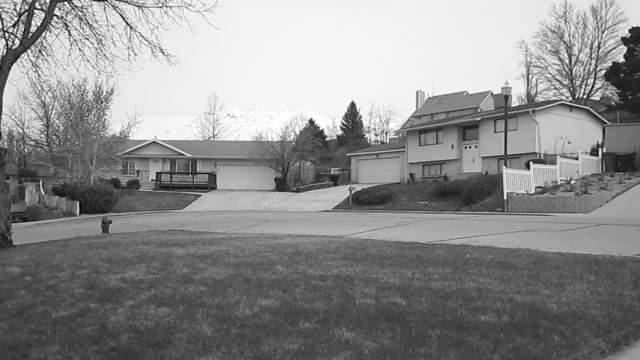

Image 2: 


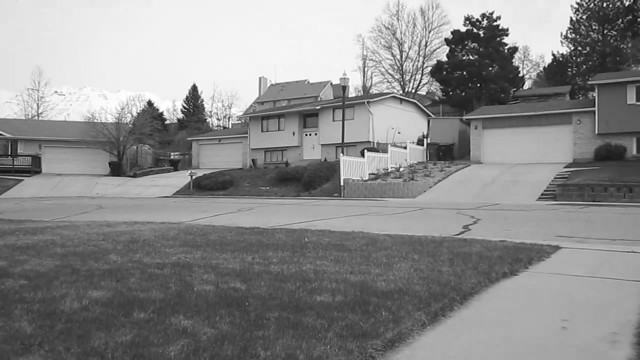

Image 3: 


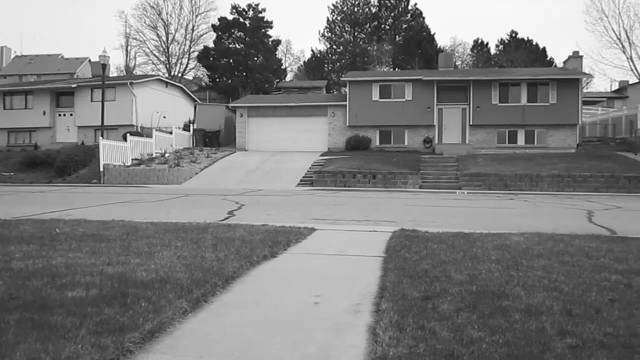

In [3]:
print("Image 1: ")
displayImage(img1_mat)

print("Image 2: ")
displayImage(img2_mat)

print("Image 3: ")
displayImage(img3_mat)

Scale Invariant Feature Transform (SIFT) is an amazing tool that finds points of correspondace between two different images. It is robust to scale and shift. Using these points of correspondance, we compute a Homography Matrix $H$. The points used to compute this matrix are randomly sampled and hence, it is necessary to evaluate the performance of $H$ on the complete figure. 

We do this evaluation using other points of correspondance to build a consensus set.  

Function to implement **RANSAC** - Random Sample Consensus.

In [4]:
from sift import sift as sift_corresp
from scipy import linalg

def run_ransac(corresp1, corresp2):
    R = 4
    consensus_set = []
    iter = 1
    epsilon = 10

    # until the consensus sent becomes large enough 
    while len(consensus_set) < 0.8 * (len(corresp1) - R) and iter <= 50:
        # take R number of random indices
        indices_random = [np.random.randint(0, len(corresp1)) for i in range(R)]
        
        # select those points from the correspondance points
        pts_1 = corresp1[indices_random]
        pts_2 = corresp2[indices_random]

        # calculate homography using these four points
        # construct matrix A
        A = np.zeros((8, 9))
        for i in range(R):
            A[2*i]   = np.array((
                                    pts_2[i, 0], pts_2[i, 1], 1, 0, 0, 0,
                                    -pts_1[i, 0] * pts_2[i, 0], - pts_2[i, 1] * pts_1[i, 0], -pts_1[i, 0]
                                ))
                                
            A[2*i+1] = np.array((
                                    0, 0, 0, pts_2[i, 0], pts_2[i, 1], 1,
                                    -pts_1[i, 1] * pts_2[i, 0], -pts_1[i, 1] * pts_2[i, 1], -pts_1[i, 1]
                                ))
        
        # now find the nullspace using SVD
        u, s, vt = np.linalg.svd(A)

        # last column of V
        H = vt[-1].reshape((3, 3))

        consensus_set = []

        for i in range(len(corresp1)):
            if i not in indices_random:
                x, y = corresp2[i]
                (xdd, ydd, zdd) = np.matmul(H, np.array((x, y, 1)))
                xdd = xdd / zdd
                ydd = ydd / zdd 

                dist = np.sqrt((xdd - corresp1[i, 0]) ** 2 + (ydd - corresp1[i, 1]) ** 2)

                if dist < epsilon:
                    consensus_set.append(i)


        print("Iter: ", iter,", |C| = ", len(consensus_set))
        iter += 1

    return H
            

Let's compute $H_{21}$

In [5]:
corresp1_h21, corresp2_h21 = sift_corresp(img1_mat, img2_mat)
h21 = run_ransac(corresp1_h21, corresp2_h21)

Iter:  1 , |C| =  137
Iter:  2 , |C| =  308


Now compute $H_{23}$

In [6]:
corresp1_h23, corresp2_h23 = sift_corresp(img3_mat, img2_mat)
h23 = run_ransac(corresp1_h23, corresp2_h23)

Iter:  1 , |C| =  321


We now have the homography matrices $H_{21}$ and $H_{23}$.

Next step is to stitch the images together. 

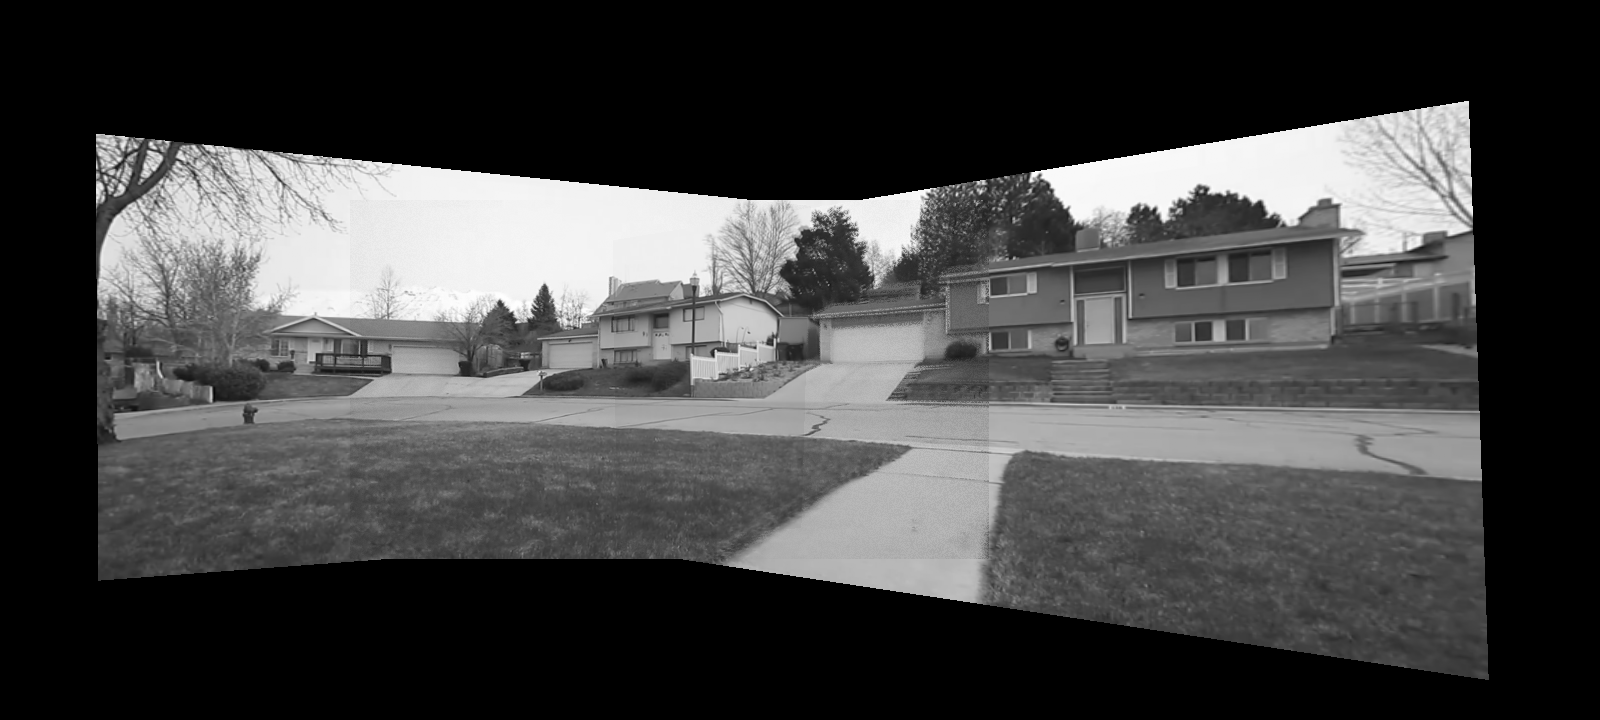

In [53]:
# Bilinear Interpolation for Target to Source Mapping  
def bilinear_interpolation(xs, ys, source_array):
    xs_flr = int(np.floor(xs))
    ys_flr = int(np.floor(ys))

    if (0 <= xs < source_array.shape[0] - 1) and (
        0 <= ys < source_array.shape[1] - 1
    ):
        a = xs - xs_flr
        b = ys - ys_flr
        intensity = (
            (1 - a) * (1 - b) * source_array[xs_flr, ys_flr]
            + (1 - a) * b * source_array[xs_flr, ys_flr + 1]
            + a * (1 - b) * source_array[xs_flr + 1, ys_flr]
            + a * b * source_array[xs_flr + 1, ys_flr + 1]
        )
    else:
        intensity = 0

    return intensity

def BlendValues(array):
    zero_indices = np.where(array == 0)[0]
    non_zero_indices = np.where(array != 0)[0]

    if len(zero_indices) > 0 and len(non_zero_indices) > 0:
        array[zero_indices] = array[np.random.choice(non_zero_indices)]

    return np.mean((array))

def stitch_canvas(img1_mat, img2_mat, img3_mat, h21, h23, rowScale = 2, colScale = 2.5, offsetRow = 200, offsetColumn = 350):
    canvasRows = int(img1_mat.shape[0] * rowScale)
    canvasColumns = int(img1_mat.shape[1] * colScale) 
    canvas = np.zeros((canvasRows, canvasColumns)).astype(np.uint8)

    for ii in range(canvasRows):
        for jj in range(canvasColumns):
            
            i = ii - offsetRow
            j = jj - offsetColumn

            tmp = np.matmul(h21, (i, j, 1))
            i1 = tmp[0] / tmp[2]
            j1 = tmp[1] / tmp[2]

            tmp = np.matmul(h23, (i, j, 1))
            i3 = tmp[0] / tmp[2]
            j3 = tmp[1] / tmp[2]

            v1 = bilinear_interpolation(i1, j1, img1_mat)
            v2 = bilinear_interpolation(i, j, img2_mat)
            v3 = bilinear_interpolation(i3, j3, img3_mat)

            canvas[ii, jj] = BlendValues(np.array((v1, v2, v3)))
    
    return canvas

canvas = stitch_canvas(img1_mat, img2_mat, img3_mat, h21, h23)

displayImage(canvas)
saveArrAsImage(canvas, filepath="canvas.png", file_format="PNG")      


This looks great!
Note that in the function `BlendValues()` function, we replaced all zeros with other non zero values so as to retain a uniform brightness throughout the image. 

Now let's experiment with a set of images I captured at my hostel. 

Image 1: 


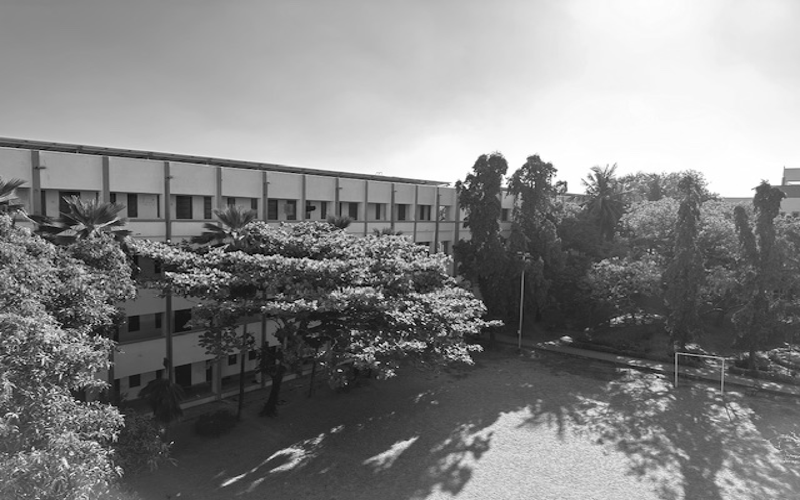

Image 2: 


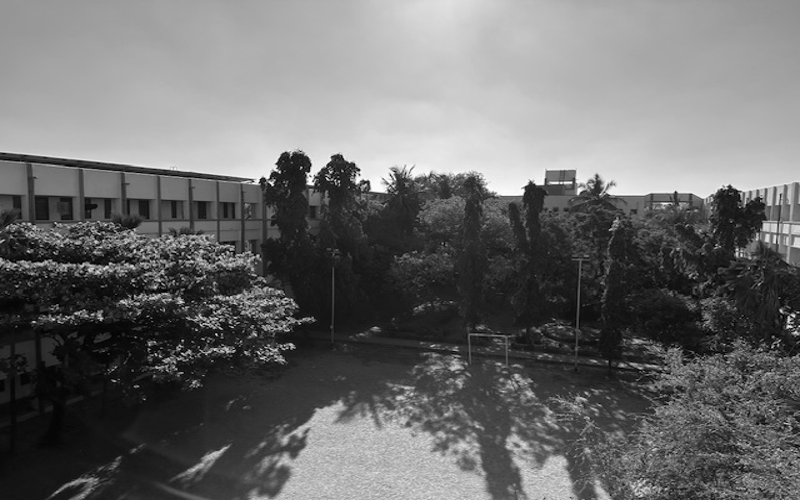

Image 3: 


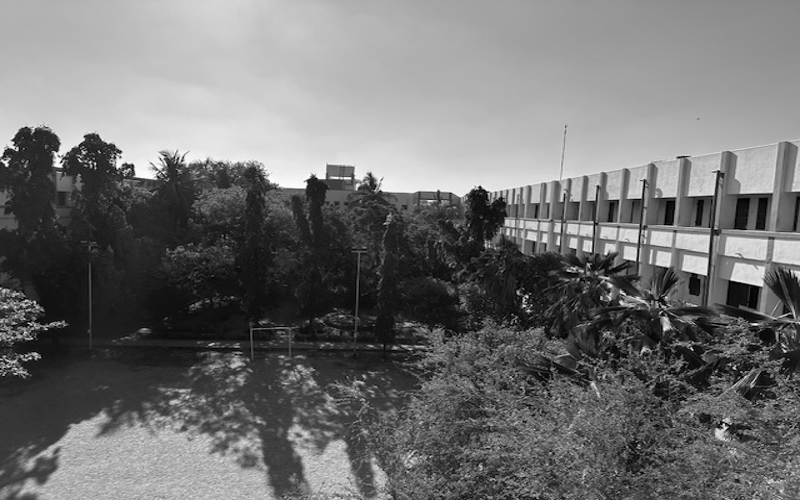

In [65]:
myimg1_mat = (image2array("myimg1.png", colour=True))
myimg2_mat = (image2array("myimg2.png", colour=True))
myimg3_mat = (image2array("myimg3.png", colour=True))

print("Image 1: ")
displayImage(myimg1_mat)

print("Image 2: ")
displayImage(myimg2_mat)

print("Image 3: ")
displayImage(myimg3_mat)

Now compute homography.

Iter:  1 , |C| =  5
Iter:  2 , |C| =  260
Iter:  3 , |C| =  316
Iter:  4 , |C| =  589
Iter:  1 , |C| =  582


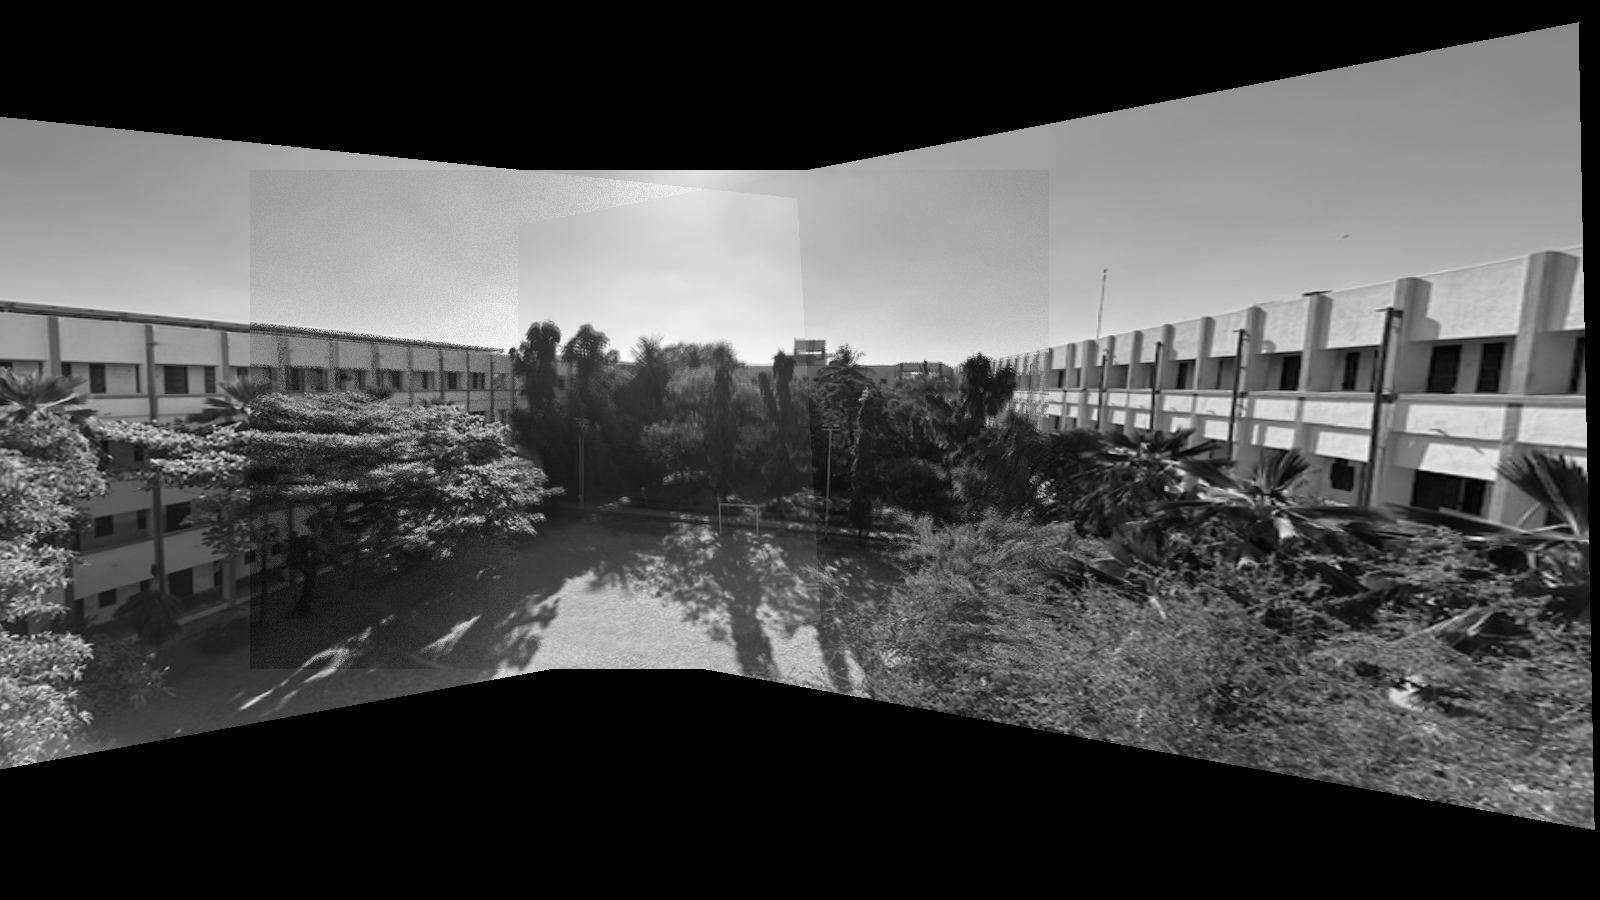

In [68]:
corresp1_h21, corresp2_h21 = sift_corresp(myimg1_mat, myimg2_mat)
h21 = run_ransac(corresp1_h21, corresp2_h21)

corresp1_h23, corresp2_h23 = sift_corresp(myimg3_mat, myimg2_mat)
h23 = run_ransac(corresp1_h23, corresp2_h23)

mycanvas = stitch_canvas(myimg1_mat, myimg2_mat, myimg3_mat, h21, h23, rowScale=1.8, colScale=2, offsetRow=170, offsetColumn=250)

displayImage(mycanvas)
saveArrAsImage(mycanvas, filepath="mycanvas.png", file_format="PNG")      


#### Conclusion
Thus, we have demonstrated alignment and stitching of images as a very interesting process, mathematically. We understood theory through implementation.  